In [ ]:
import numpy as np
np.random.seed(1337)
import tensorflow as tf
np.random.seed(1337)
from keras.preprocessing import image
import matplotlib.pyplot as plt
import keras as kt
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
dir = '/content/drive/MyDrive/CapstoneProject/acne_img'

datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_ds = datagen.flow_from_directory(
    dir,
    subset="training",
    seed=0,
    target_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = datagen.flow_from_directory(
    dir,
    subset="validation",
    seed=0,
    target_size=(img_height, img_width),
    batch_size=batch_size)
     

Found 278 images belonging to 5 classes.
Found 67 images belonging to 5 classes.


In [ ]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['Blackhead', 'Nodules', 'Papule', 'Pustules', 'Whitehead']


In [ ]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
Counter(train_ds.classes)

Counter({0: 41, 1: 48, 2: 40, 3: 104, 4: 45})

In [ ]:
from sklearn.utils import class_weight

weights = compute_class_weight(class_weight = "balanced",
                               classes = np.unique(train_ds.classes),
                               y = train_ds.classes)
weights

array([1.35609756, 1.15833333, 1.39      , 0.53461538, 1.23555556])

In [ ]:
cw = dict(zip(np.unique(train_ds.classes), weights))
cw

{0: 1.3560975609756099,
 1: 1.1583333333333334,
 2: 1.39,
 3: 0.5346153846153846,
 4: 1.2355555555555555}

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset="training",
    seed=0,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset="validation",
    seed=0,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 345 files belonging to 5 classes.
Using 276 files for training.
Found 345 files belonging to 5 classes.
Using 69 files for validation.


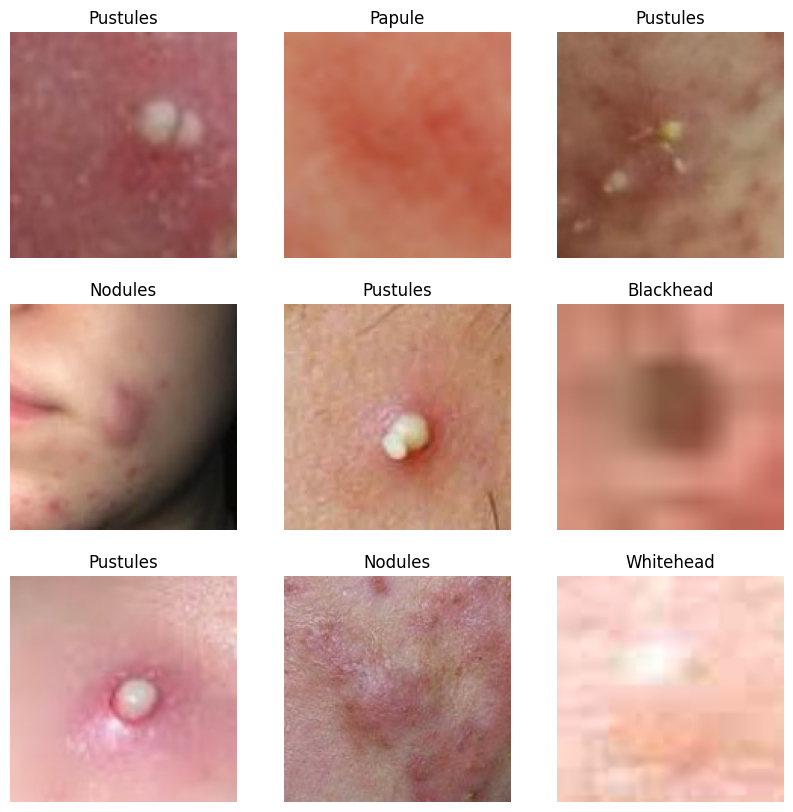

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical",seed=0),
  keras.layers.RandomRotation(0.1,seed=0),
])

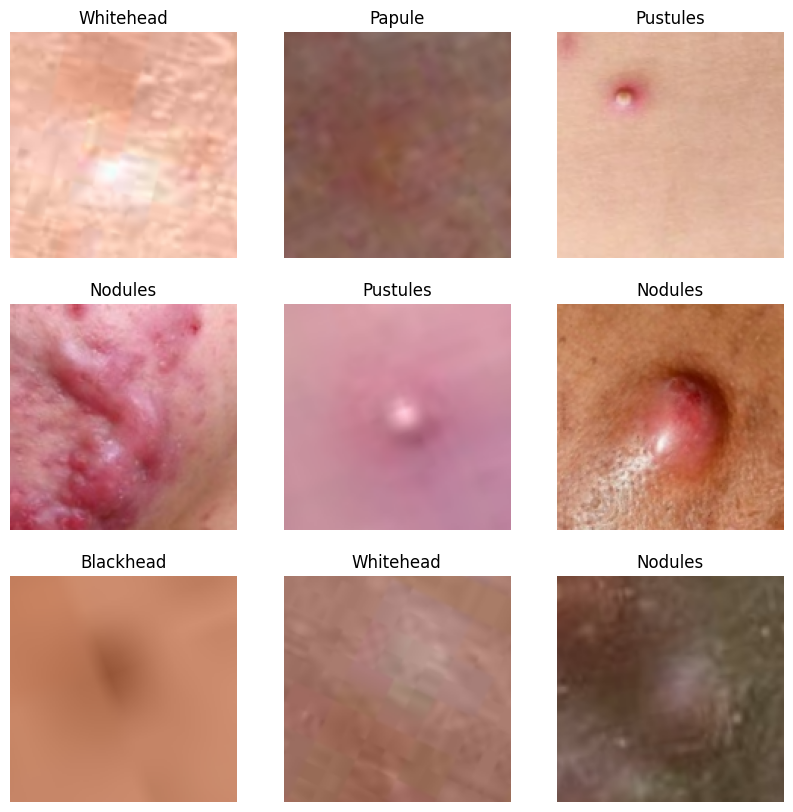

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# **Model**

In [ ]:
num_classes = 5

model = keras.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
hist = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=cw,
    shuffle=False
)
     

Epoch 1/100
9/9 [==============================] - 19s 2s/step - loss: 1.5959 - accuracy: 0.2138 - val_loss: 1.5282 - val_accuracy: 0.4493
Epoch 2/100
9/9 [==============================] - 7s 680ms/step - loss: 1.5031 - accuracy: 0.2681 - val_loss: 1.4415 - val_accuracy: 0.4928
Epoch 3/100
9/9 [==============================] - 8s 834ms/step - loss: 1.4352 - accuracy: 0.3007 - val_loss: 1.3629 - val_accuracy: 0.4638
Epoch 4/100
9/9 [==============================] - 7s 786ms/step - loss: 1.3907 - accuracy: 0.3877 - val_loss: 1.3407 - val_accuracy: 0.5362
Epoch 5/100
9/9 [==============================] - 7s 675ms/step - loss: 1.3219 - accuracy: 0.4167 - val_loss: 1.3032 - val_accuracy: 0.4928
Epoch 6/100
9/9 [==============================] - 7s 682ms/step - loss: 1.2717 - accuracy: 0.4420 - val_loss: 1.2794 - val_accuracy: 0.6812
Epoch 7/100
9/9 [==============================] - 8s 831ms/step - loss: 1.2234 - accuracy: 0.5000 - val_loss: 1.1990 - val_accuracy: 0.6377
Epoch 8/100
9/9

<Axes: >

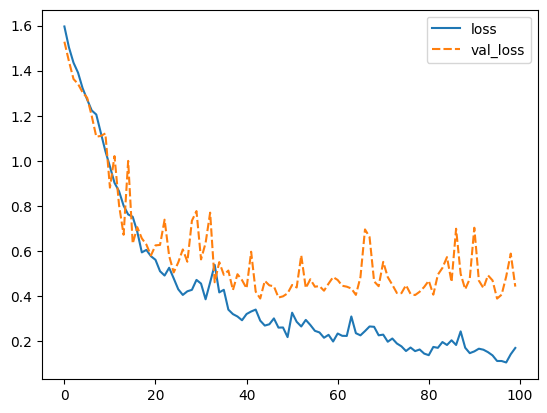

In [ ]:
sns.lineplot(data={idx: hist.history[idx] for idx in ['loss', 'val_loss']})

<Axes: >

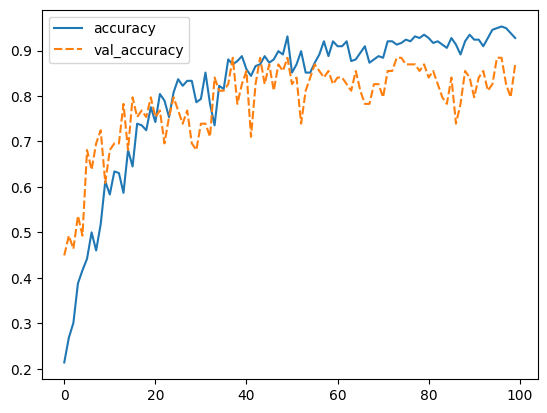

In [ ]:
sns.lineplot(data={idx: hist.history[idx] for idx in ['accuracy', 'val_accuracy']})

In [ ]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print(test_acc)

3/3 - 0s - loss: 0.4418 - accuracy: 0.8696 - 441ms/epoch - 147ms/step
0.8695651888847351


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)       

In [ ]:
#model.save('drive/MyDrive/acne_model')

# **Confusion Matrix**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

from keras.layers import concatenate

predictions = np.array([])
true =  np.array([])

for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(new_model.predict(x), axis=-1)])
  true = np.concatenate([true, y.numpy()])

class_names = ['Blackhead', 'Nodules', 'Papule', 'Pustules', 'Whitehead']
print(classification_report(true, predictions, target_names=class_names,digits =4))

In [ ]:
predictions

In [ ]:
true

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap='hot')
plt.savefig('confusionmatrix.png')
plt.show()